# Exploratory Data Analysis (Phase 3)

#### Input: 
   dataset.csv created in stage 2.
#### Output:
   Various parameters required for model training.
#### Algorithm:
   a) Clean dataset.<br>
   b) Finding shape of features created by tfidfVectorizer.<br>
   c) Calculate max sequence length to train doc2vec model.<br>
   d) Compute truncated components for SVD.<br>
   e) Getting insights of data.<br>

Get all the required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from collections import Counter
%matplotlib notebook

Import dataset.

In [2]:
df = pd.read_csv("dataset.csv", names=["files", "keywords", "weights"])
df.dropna(inplace=True)

In [3]:
df.head()

,files,keywords,weights
0,User Application for Shop Floor Automation usi...,stable connectivity category data collection e...,165.796429
1,User Application for Shop Floor Automation usi...,predictive tool category development environme...,146.191667
2,User Application for Shop Floor Automation usi...,parameter minimum requirement cpu speed ram...,129.714379
3,User Application for Shop Floor Automation usi...,quirement success success failure success succ...,113.209091
4,User Application for Shop Floor Automation usi...,lled datatype validation unknown user conn...,98.419441


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107843 entries, 0 to 112080
Data columns (total 3 columns):
files       107843 non-null object
keywords    107843 non-null object
weights     107843 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


Clean dataset

In [5]:
blank_indexes = np.array(df.loc[df["keywords"].apply(lambda x: len(x) == 1)].index)

In [6]:
df.drop(labels=blank_indexes, inplace=True)

1) Finding unique files in dataset.

In [7]:
df["files"].nunique()

215

2) Finding no of features in documents.

In [8]:
tf = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), min_df=25, stop_words="english")

In [9]:
tfidf = tf.fit_transform(df["keywords"])

In [10]:
len(tf.get_feature_names())

2246

3) Finding max sequence length

In [11]:
max(df["keywords"].apply(lambda x: len(x.split(" "))))

62

4) Finding which features are mostly describe the file

In [12]:
maxvalues_matrix = tfidf.argmax(axis=0)

In [13]:
feature_max = np.array(maxvalues_matrix.tolist()).reshape(-1)

In [14]:
len(feature_max)

2246

In [15]:
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tf.get_feature_names())

In [16]:
tfidf_matrix.head()

,ability,abnormality,abstract,abstractive,ac,accelerate,accelerate evaluate,accelerate evaluate associate,accept,acceptable,...,workstation selection,writer,writing,written,xml,year,yield,youtube,youtube video,zephyr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
tfidf_features = tf.get_feature_names()

In [18]:
feature_tfidf = {}

In [19]:
for i in range(len(tfidf_features)):
    feature_tfidf[tfidf_features[i]] = tfidf_matrix[tfidf_features[i]][feature_max[i]]

In [20]:
feature_tfidf = pd.DataFrame(feature_tfidf, index=[0])

In [21]:
feature_tfidf = pd.DataFrame(feature_tfidf.loc[0]).reset_index()

In [22]:
feature_tfidf.columns = ["words", "idf"]

In [23]:
feature_tfidf.head(5)

,words,idf
0,ability,1.0
1,abnormality,1.0
2,abstract,1.0
3,abstractive,1.0
4,ac,1.0


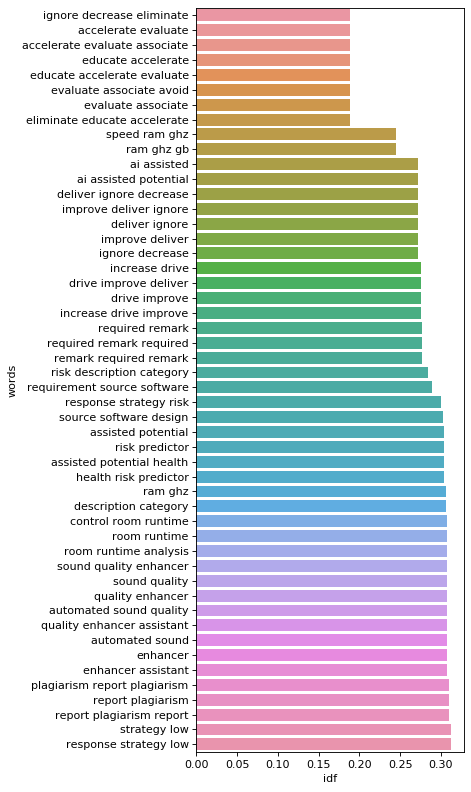

In [24]:
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x="idf", y="words", data=feature_tfidf.sort_values(by="idf")[:50])
plt.tight_layout()
plt.show()

5) Finding higher frequency words in files

In [25]:
keywords_df = df.groupby("files").agg({"keywords": lambda x: " ".join(x.tolist()).split(" ")}).reset_index()

In [26]:
keywords_df.head(5)

,files,keywords
0,2D TO 3D IMAGE CONVERSION USING_MACHINE LEARNI...,"[nvidia, gtx, , gb, graphic, card, software, d..."
1,3D-image terrain classification using machine ...,"[parameter, minimum, requirement, justication,..."
2,A CRYPTOSYSTEM FOR ENCRYPTION OF_DATA USING IM...,"[october, , , , , , , , , , , , , , , , , tabl..."
3,A NALYSIS OF G ENE R EGULATION USING_D EEP L E...,"[, , , , , , , , , , task, literature, survey,..."
4,A SYSTEM FOR LANGUAGE TRANSLATION.pdf,"[risk, description, project, scope, stability,..."


In [27]:
def plot_higher_frequency_words(index):
    sorted_dict = dict(sorted(dict(Counter(keywords_df["keywords"][index])).items(), key=lambda x: x[1], reverse=True))
    if "" in sorted_dict:
        del sorted_dict[""]
    sorted_dict = pd.DataFrame(sorted_dict, index=[0])
    sorted_dict = pd.DataFrame(sorted_dict.loc[0]).reset_index()
    sorted_dict.columns = ["words", "frequency"]
    plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.barplot(x="frequency", y="words", data=sorted_dict[:50])
    plt.tight_layout()
    plt.show()

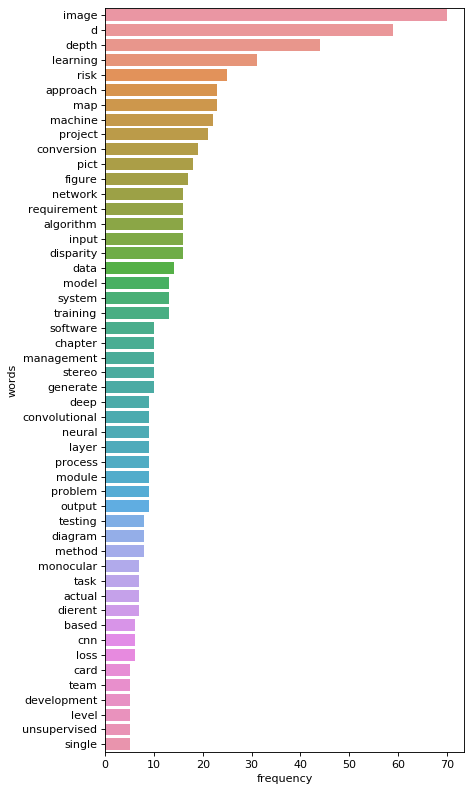

CPU times: user 618 ms, sys: 19.7 ms, total: 638 ms
Wall time: 638 ms


In [28]:
%%time
plot_higher_frequency_words(0)

6) Finding components for SVD

In [29]:
svd = TruncatedSVD(n_components=tfidf.shape[1]-1)

In [30]:
%%time
svd.fit(tfidf.toarray())

CPU times: user 14min 31s, sys: 25.2 s, total: 14min 56s
Wall time: 4min 52s


TruncatedSVD(algorithm='randomized', n_components=2245, n_iter=5,
             random_state=None, tol=0.0)

In [31]:
svd.explained_variance_ratio_

array([1.17967646e-02, 9.32510088e-03, 8.87235289e-03, ...,
       3.39566588e-36, 1.84413899e-36, 2.50793408e-37])

Text(0, 0.5, 'cumulative explained variance')

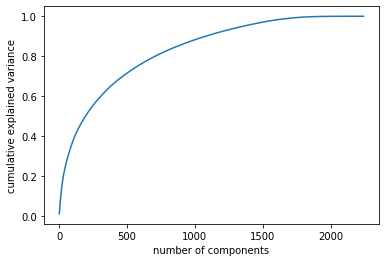

In [32]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [33]:
def select_n_components(variance_ratio, goal_variance):
    total_variance = 0.0
    n_components = 0
    
    for var in variance_ratio:
        total_variance += var
        n_components += 1
        
        if total_variance >= goal_variance:
            break
    
    return n_components

In [34]:
select_n_components(svd.explained_variance_ratio_, 0.95)

1356

In [35]:
%%time
tagged_data = [TaggedDocument(words=word_tokenize("".join(_d)), tags=[i]) for i, _d in enumerate(df["keywords"])]
doc2vec = Doc2Vec(vector_size=62, hs=1, sample=0,  min_count=25, epochs=100, seed=0, window=3, dm=1)
doc2vec.build_vocab(tagged_data)
doc2vec.train(tagged_data, total_examples=doc2vec.corpus_count, epochs=100)

CPU times: user 4min 38s, sys: 1min 4s, total: 5min 43s
Wall time: 3min 59s


In [36]:
pca = PCA(n_components=3)

In [37]:
pca_transformed = pca.fit_transform(doc2vec.docvecs.vectors_docs)

In [38]:
pca_transformed = pd.DataFrame(pca_transformed, columns=["col1", "col2", "col3"])

In [39]:
pca_transformed.head()

,col1,col2,col3
0,-0.582274,1.168671,0.853746
1,-0.369280,1.911503,0.602902
2,0.867870,2.293727,0.206274
3,-1.938363,0.914929,1.144271
4,0.536164,0.055959,-4.171923


In [40]:
pca_transformed["col3_transformed"] = pca_transformed["col3"]*10

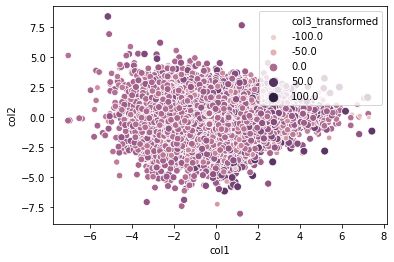

In [41]:
sns.scatterplot(x="col1", y="col2", hue="col3_transformed", data=pca_transformed, size="col3_transformed")

In [43]:
%matplotlib notebook

<IPython.core.display.Javascript object>


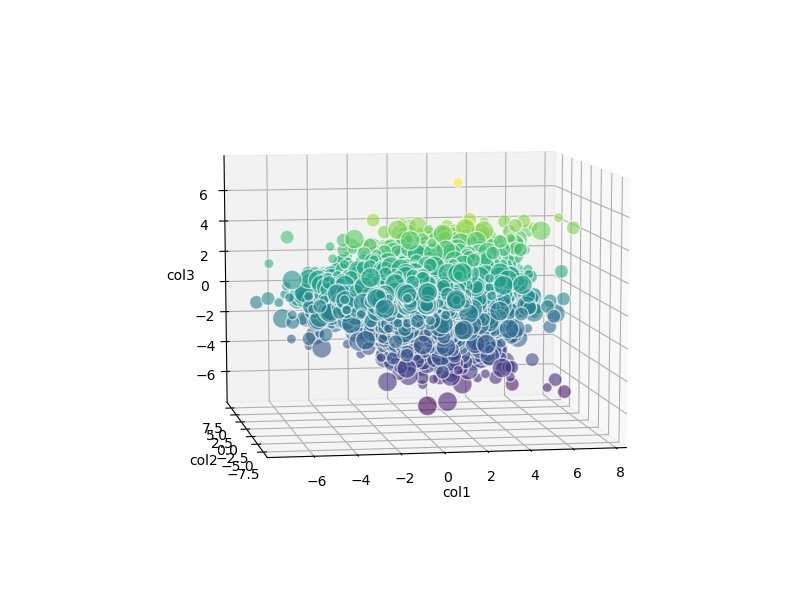

Text(0.5, 0, 'col3')

In [45]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

xs = pca_transformed["col1"]
ys = pca_transformed["col2"]
zs = pca_transformed["col3"]
ax.scatter(xs, ys, zs, s=[50, 100, 200], c=zs, alpha=0.6, edgecolors='w')

ax.set_xlabel('col1')
ax.set_ylabel('col2')
ax.set_zlabel('col3')

In [46]:
kmeans = KMeans(n_clusters=6)

In [48]:
kmeans.fit(doc2vec.docvecs.vectors_docs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
pca_transformed["labels"] = kmeans.labels_

In [53]:
pca_transformed.head()

,col1,col2,col3,col3_transformed,labels
0,-0.582274,1.168671,0.853746,8.537458,2
1,-0.369280,1.911503,0.602902,6.029020,2
2,0.867870,2.293727,0.206274,2.062741,2
3,-1.938363,0.914929,1.144271,11.442708,1
4,0.536164,0.055959,-4.171923,-41.719227,5


In [55]:
pca_transformed.drop("col3_transformed", inplace=True, axis=1)

<IPython.core.display.Javascript object>


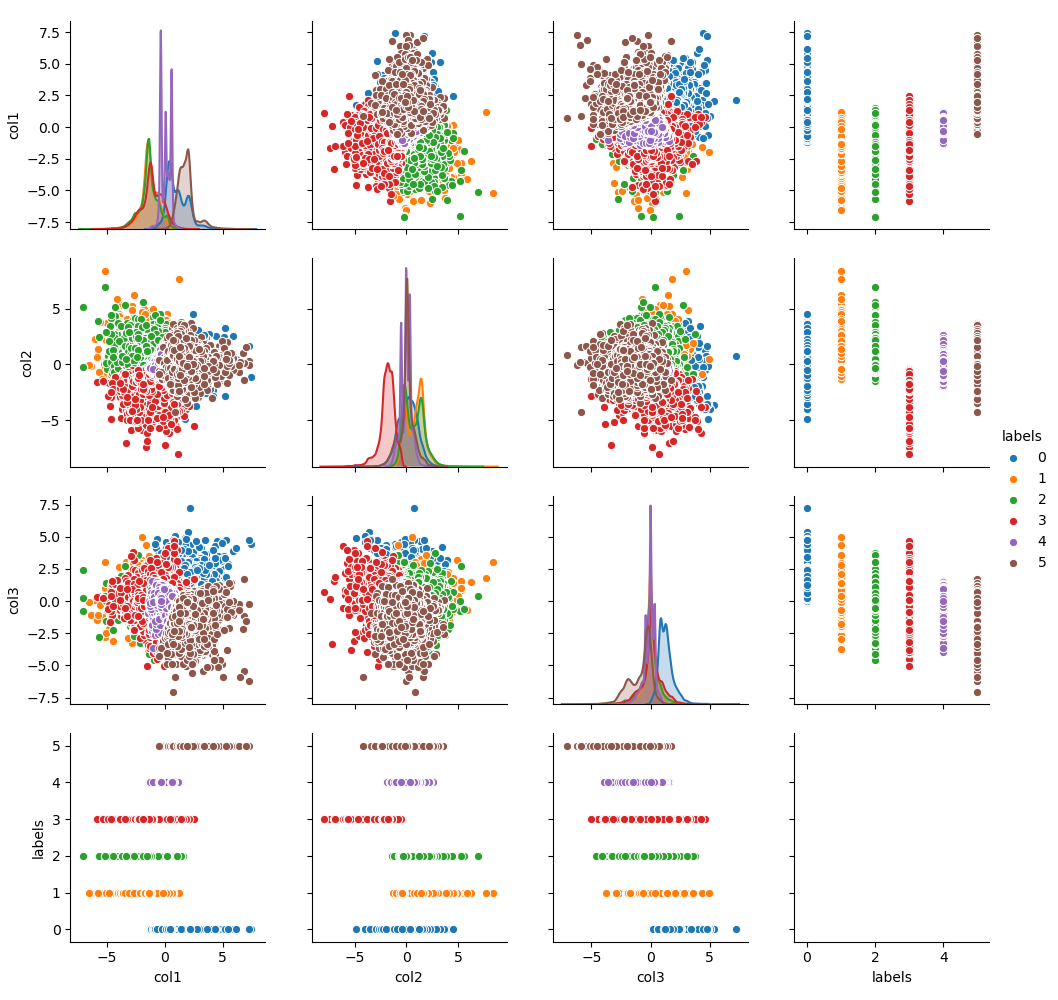

/home/dhiraj/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/dhiraj/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [61]:
sns.pairplot(data=pca_transformed, hue="labels")

# Observations

1) Total files: 215<br>
2) Features trained by tfidf vectorizer: 2256<br>
3) Max sequence length: 62<br>
4) Features idf are: trigrams < bigrams < unigrams<br>
5) Components for truncated SVD: 1356<br>
6) Clusters for doc2vec: 6

# End of Phase 3